## **Import all packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.collections import PolyCollection

## **Upload datasets**

In [2]:
# Upload datasets
train_df = pd.read_csv('train.csv')
building_df = pd.read_csv('building_metadata.csv')
weather_train_df = pd.read_csv('weather_train.csv')

In [3]:
# Check each dataframe's shape
print(train_df.shape, building_df.shape, weather_train_df.shape)

(20216100, 4) (1449, 6) (139773, 9)


In [4]:
# Check columns present in each dataframe

print("Train DataFrame Columns:")
print(train_df.columns)

print("Building DataFrame Columns:")
print(building_df.columns)

print("Weather Train DataFrame Columns:")
print(weather_train_df.columns)

Train DataFrame Columns:
Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')
Building DataFrame Columns:
Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')
Weather Train DataFrame Columns:
Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')


In [5]:
# Join training dataset and building metadata on building id
training_joined = train_df.merge(building_df, how='left', on='building_id')

# Join training_joined and Weather dataset on site_id and timestamp
final_df = training_joined.merge(weather_train_df, how='left', on=['site_id', 'timestamp'])

# Split train/test
train, test = train_test_split(final_df, test_size=0.3, random_state=21)

In [6]:
# What are the shapes of the dataframes?
print(f'Training joined shape: {training_joined.shape}')
print(f'Final df shape: {final_df.shape}')
print(f"Train shape: {train.shape}\nTest shape: {test.shape}")

Training joined shape: (20216100, 9)
Final df shape: (20216100, 16)
Train shape: (14151270, 16)
Test shape: (6064830, 16)


In [7]:
train.tail(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
10294479,887,2,2016-07-08 01:00:00,33.550,9,Lodging/residential,69754,NaN,NaN,32.8,0.0,21.7,0.0,1011.6,150.0,5.1
7945161,1055,0,2016-05-27 07:00:00,100.172,12,Education,86714,NaN,4.0,10.1,7.0,8.1,NaN,1018.0,40.0,2.0


# **Exploratory Data Analysis**

**Buildings by primary use**

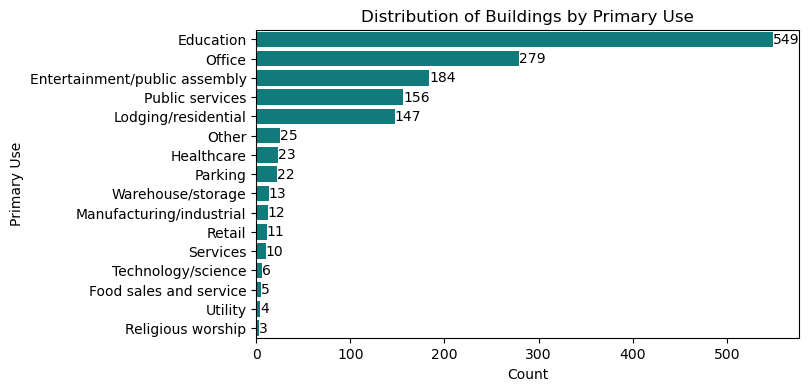

In [8]:
# Selecting desired columns from train DataFrame
unique_buildings_df = train[['building_id', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']]

# Keeping only unique rows based on building_id
unique_buildings_df = unique_buildings_df.drop_duplicates(subset=['building_id'])

# Set color
color = 'darkcyan'

# Order the dataframe by primary_use and get the counts
primary_use_counts = unique_buildings_df['primary_use'].value_counts().sort_values(ascending=False)

# Visualize distribution of buildings by primary use
plt.figure(figsize=(7, 4))
sns.countplot(y='primary_use', data=unique_buildings_df, order=primary_use_counts.index, color=color)
plt.title('Distribution of Buildings by Primary Use')
plt.xlabel('Count')
plt.ylabel('Primary Use')

# Add labels showing the total number of buildings for each primary use
for index, value in enumerate(primary_use_counts):
    plt.text(value, index, str(value), ha='left', va='center')

plt.show()

**Weather Data - Temprature Distribution**

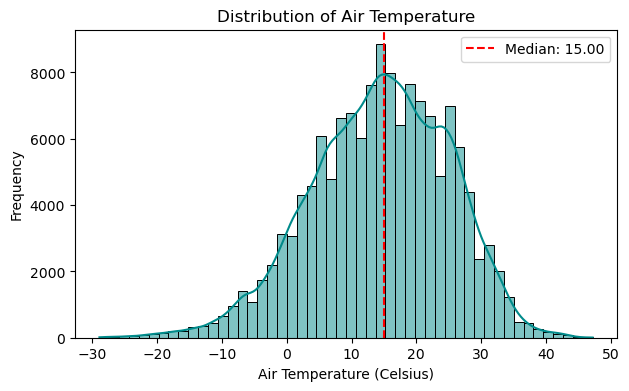

In [9]:
# Calculate median
median_temp = weather_train_df['air_temperature'].median()

# Plot histogram of air temperature
plt.figure(figsize=(7, 4))
sns.histplot(weather_train_df['air_temperature'], bins=50, kde=True, color='darkcyan')
plt.title('Distribution of Air Temperature')
plt.xlabel('Air Temperature (Celsius)')
plt.ylabel('Frequency')

# Mark the median on the plot
plt.axvline(median_temp, color='red', linestyle='--', label=f'Median: {median_temp:.2f}')
plt.legend()

plt.show()

**Air Temperature Evolution Over Time**

In [10]:
# Convert timestamp to datetime format if it's not already
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])

# Reset 'timestamp' from index to a regular column
weather_train_df.reset_index(inplace=True)

# Create 'date' and 'time' columns
weather_train_df['date'] = weather_train_df['timestamp'].dt.date
weather_train_df['time'] = weather_train_df['timestamp'].dt.time

In [11]:
# Check for missing values in weather_df
missing_values = weather_train_df.isnull().sum()

# Print the count of missing values for each column
#print("Missing Values in weather_train_df before interpolation:")
#print(missing_values)

# Fill missing values in 'air_temperature' using linear interpolation based on the index order
weather_train_df['interpolated_air_temperature'] = weather_train_df['air_temperature'].interpolate(method='index')

# Recalculate missing values after interpolation
missing_values = weather_train_df.isnull().sum()

# Print the count of missing values for each column after interpolation
print("Missing Values in weather_train_df after interpolation:")
print(missing_values)

Missing Values in weather_train_df after interpolation:
index                               0
site_id                             0
timestamp                           0
air_temperature                    55
cloud_coverage                  69173
dew_temperature                   113
precip_depth_1_hr               50289
sea_level_pressure              10618
wind_direction                   6268
wind_speed                        304
date                                0
time                                0
interpolated_air_temperature        0
dtype: int64


In [12]:
# Group by date and site_id and calculate summary statistics
weather_summary = weather_train_df.groupby(['date', 'site_id']).agg({
    'air_temperature': ['min', 'max', 'mean'],
    'interpolated_air_temperature': ['min', 'max', 'mean'],
    'cloud_coverage': ['min', 'max', 'mean'],
    'dew_temperature': ['min', 'max', 'mean'],
    'precip_depth_1_hr': ['min', 'max', 'mean'],
    'sea_level_pressure': ['min', 'max', 'mean'],
    'wind_direction': ['min', 'max', 'mean'],
    'wind_speed': ['min', 'max', 'mean']
}).reset_index()

# Flatten the multi-level columns
weather_summary.columns = ['_'.join(col).strip() for col in weather_summary.columns.values]

# Group by date and site_id and calculate summary statistics - MONTHLY FOR CLEARER GRAPH

# Convert the 'date' column to datetime format
weather_train_df['date'] = pd.to_datetime(weather_train_df['date'])

weather_summary_monthly = weather_train_df.groupby([weather_train_df['date'].dt.to_period("M"), 'site_id']).agg({
    'air_temperature': ['min', 'max', 'mean'],
    'interpolated_air_temperature': ['min', 'max', 'mean'],
    'cloud_coverage': ['min', 'max', 'mean'],
    'dew_temperature': ['min', 'max', 'mean'],
    'precip_depth_1_hr': ['min', 'max', 'mean'],
    'sea_level_pressure': ['min', 'max', 'mean'],
    'wind_direction': ['min', 'max', 'mean'],
    'wind_speed': ['min', 'max', 'mean']
}).reset_index()

# Flatten the multi-level columns
weather_summary_monthly.columns = ['_'.join(col).strip() for col in weather_summary_monthly.columns.values]

weather_summary_monthly.tail(3)

,date_,site_id_,air_temperature_min,air_temperature_max,air_temperature_mean,interpolated_air_temperature_min,interpolated_air_temperature_max,interpolated_air_temperature_mean,cloud_coverage_min,cloud_coverage_max,...,precip_depth_1_hr_mean,sea_level_pressure_min,sea_level_pressure_max,sea_level_pressure_mean,wind_direction_min,wind_direction_max,wind_direction_mean,wind_speed_min,wind_speed_max,wind_speed_mean
189,2016-12,13,-28.9,5.0,-6.190983,-28.9,5.0,-6.190983,0.0,9.0,...,0.415882,997.0,1036.7,1018.629046,0.0,360.0,229.210884,0.0,13.4,4.918170
190,2016-12,14,-10.0,16.7,2.741263,-10.0,16.7,2.741263,0.0,9.0,...,0.998656,997.3,1040.3,1019.583333,0.0,360.0,217.792916,0.0,10.8,3.157873
191,2016-12,15,-14.4,11.7,-1.472789,-14.4,11.7,-1.472789,0.0,4.0,...,0.763636,995.8,1042.2,1018.645582,0.0,360.0,214.678523,0.0,11.3,4.697687


**Temperature evolution over time for each site_id, showing each month's mean temperature**

In [13]:
# Convert 'date_' column to string as date_ period[M] won't work for the graph
weather_summary_monthly['date_'] = weather_summary_monthly['date_'].astype(str)

# Pivot the original DataFrame to have one row for each date and one column for each site_id
interpolated_temperature_pivot = weather_summary_monthly.pivot_table(index='date_', columns='site_id_', values='interpolated_air_temperature_mean')

# Reset the index to make 'date_' a regular column
interpolated_temperature_pivot.reset_index(inplace=True)

# Get the number of unique site_ids
num_site_ids = len(interpolated_temperature_pivot.columns) - 1

# Create a list of colors from the 'viridis' colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_site_ids))

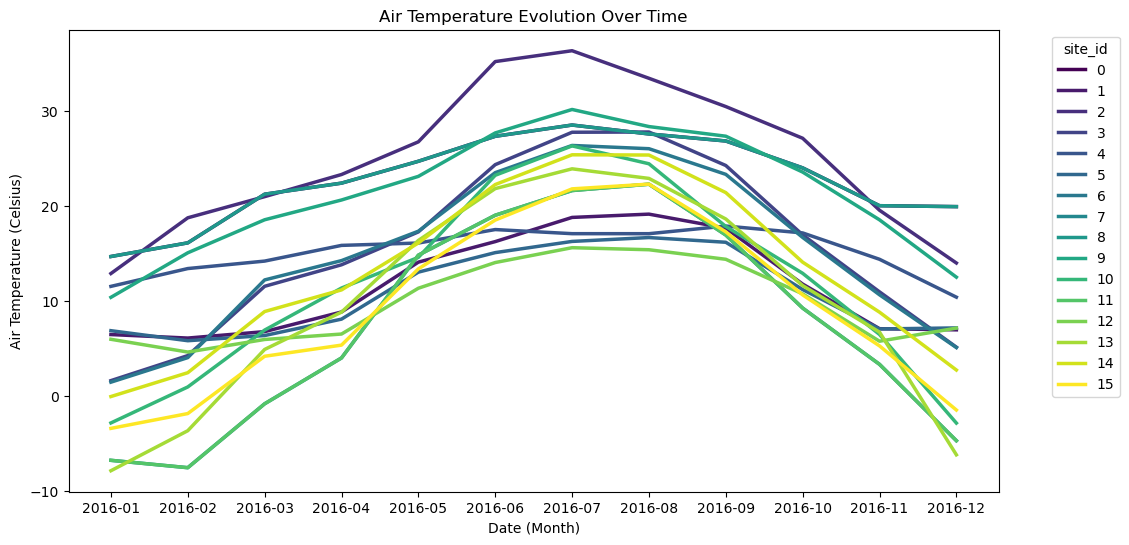

In [14]:
# Plot temperature evolution over time for each site_id - MONTHLY
plt.figure(figsize=(12, 6))
for i, column in enumerate(interpolated_temperature_pivot.columns[1:]):
    sns.lineplot(x='date_', y=column, data=interpolated_temperature_pivot, label=column, linewidth=2.5, color=colors[i])
plt.title('Air Temperature Evolution Over Time')
plt.xlabel('Date (Month)')
plt.ylabel('Air Temperature (Celsius)')
plt.legend(title='site_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Analyse buildings and consumption.**    
**{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}**

**Daily consumption**

In [15]:
# Convert timestamp to datetime format if it's not already
train['timestamp'] = pd.to_datetime(train['timestamp'])

# Create 'date' and 'time' columns
train['date'] = train['timestamp'].dt.date
train['time'] = train['timestamp'].dt.time

C:\Users\c22121504\AppData\Local\Temp\ipykernel_20384\1194517821.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([f'{int(t):,}' for t in yticks])
C:\Users\c22121504\AppData\Local\Temp\ipykernel_20384\1194517821.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([f'{int(t):,}' for t in yticks])


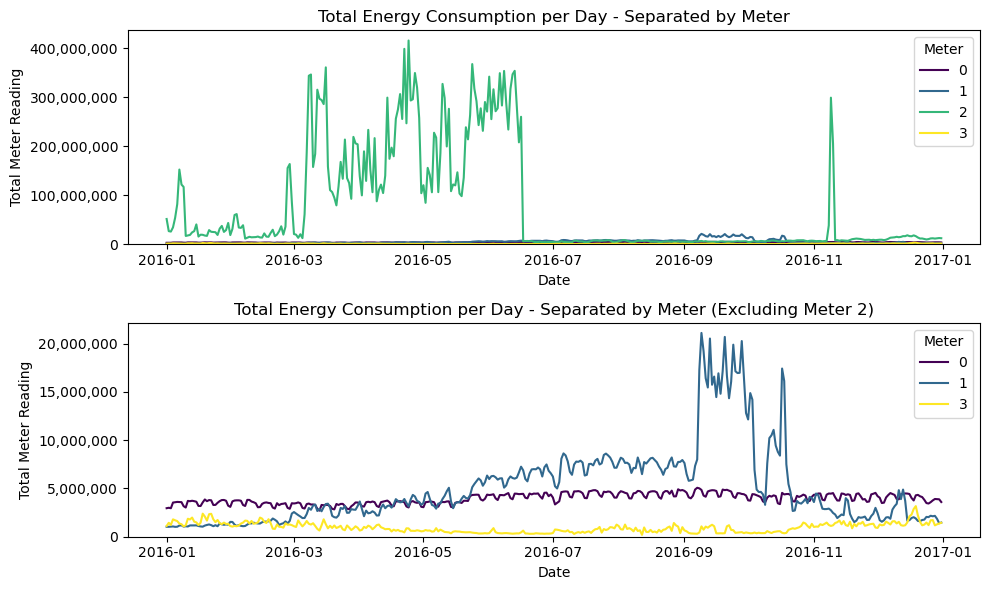

In [16]:
# Group by date and calculate the sum of meter_reading for each meter
daily_energy_consumption_by_meter = train.groupby(['date', 'meter'])['meter_reading'].sum().reset_index()

# Filter out meter 2 from the DataFrame
daily_energy_consumption_by_meter_filtered = daily_energy_consumption_by_meter[daily_energy_consumption_by_meter['meter'] != 2]

# Create a figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Plot the first graph
sns.lineplot(x='date', y='meter_reading', hue='meter', data=daily_energy_consumption_by_meter, palette='viridis', ax=axes[0])
axes[0].set_title('Total Energy Consumption per Day - Separated by Meter')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Meter Reading')
axes[0].legend(title='Meter')
axes[0].set_ylim(0, None)
yticks = axes[0].get_yticks()
axes[0].set_yticklabels([f'{int(t):,}' for t in yticks])

# Plot the second graph
sns.lineplot(x='date', y='meter_reading', hue='meter', data=daily_energy_consumption_by_meter_filtered, palette='viridis', ax=axes[1])
axes[1].set_title('Total Energy Consumption per Day - Separated by Meter (Excluding Meter 2)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Meter Reading')
axes[1].legend(title='Meter')
axes[1].set_ylim(0, None)
yticks = axes[1].get_yticks()
axes[1].set_yticklabels([f'{int(t):,}' for t in yticks])

# Adjust layout
plt.tight_layout()
plt.show()

**Daily consumption vs. temperature**

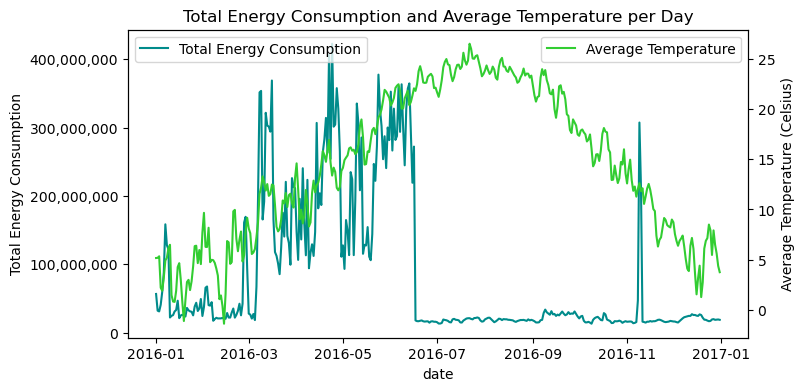

In [17]:
# Group by date and calculate the sum of meter_reading
daily_energy_consumption = train.groupby('date')['meter_reading'].sum().reset_index()

# Group by date and calculate the mean of air_temperature_mean across all sites
average_temperature = weather_summary.groupby('date_')['air_temperature_mean'].mean().reset_index()

# Create a line plot for total energy consumption
plt.figure(figsize=(8, 4))

# Total Energy Consumption line
sns.lineplot(x='date', y='meter_reading', data=daily_energy_consumption, label='Total Energy Consumption', color='darkcyan')

# Function to format y-axis ticks as whole numbers
def format_ticks(x, pos):
    return f'{int(x):,}'

# Apply the formatting function to the left y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.ylabel('Total Energy Consumption', color='black')
plt.legend(loc='upper left')

# Create a second y-axis for average temperature
ax2 = plt.gca().twinx()

# Average Temperature line
sns.lineplot(x='date_', y='air_temperature_mean', data=average_temperature, label='Average Temperature', ax=ax2, color='limegreen')

plt.title('Total Energy Consumption and Average Temperature per Day')
plt.xlabel('Date')

# Set y-axis labels

ax2.set_ylabel('Average Temperature (Celsius)', color='black')



plt.legend(loc='upper right')
plt.show()

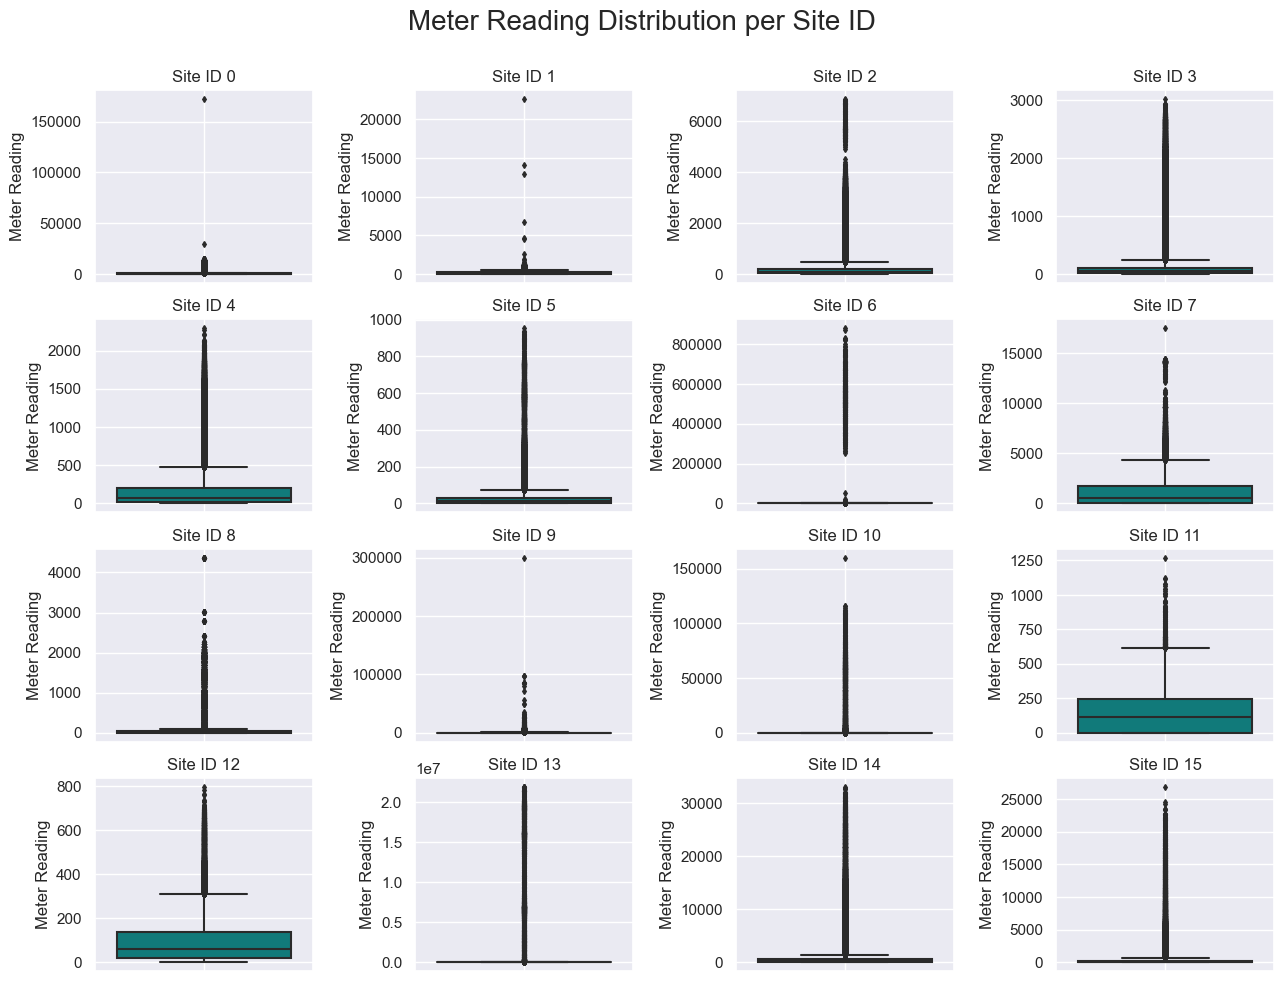

In [103]:
# Get unique site_ids
unique_site_ids = train['site_id'].sort_values(ascending=True).unique()

# Set up subplots
num_plots = len(unique_site_ids)
num_cols = 4 
num_rows = 4 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 10))

# Flatten axes if necessary
if num_plots > 1:
    axes = axes.flatten()

# Loop through each site_id
for i, siteid in enumerate(unique_site_ids):
    # Filter data for the current site_id
    data_site = train[train['site_id'] == siteid]
    
    # Plot data for the current site_id
    sns.boxplot(y='meter_reading', data=data_site, ax=axes[i], color='darkcyan', fliersize=3)  # Set color to dark cyan and reduce fliersize
    
    # Customize plot
    axes[i].set_title(f'Site ID {siteid}', fontsize=12)
    axes[i].set_ylabel('Meter Reading', fontsize=12)
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Meter Reading Distribution per Site ID", fontsize=20)
plt.show()

# **Correlation Analysis**

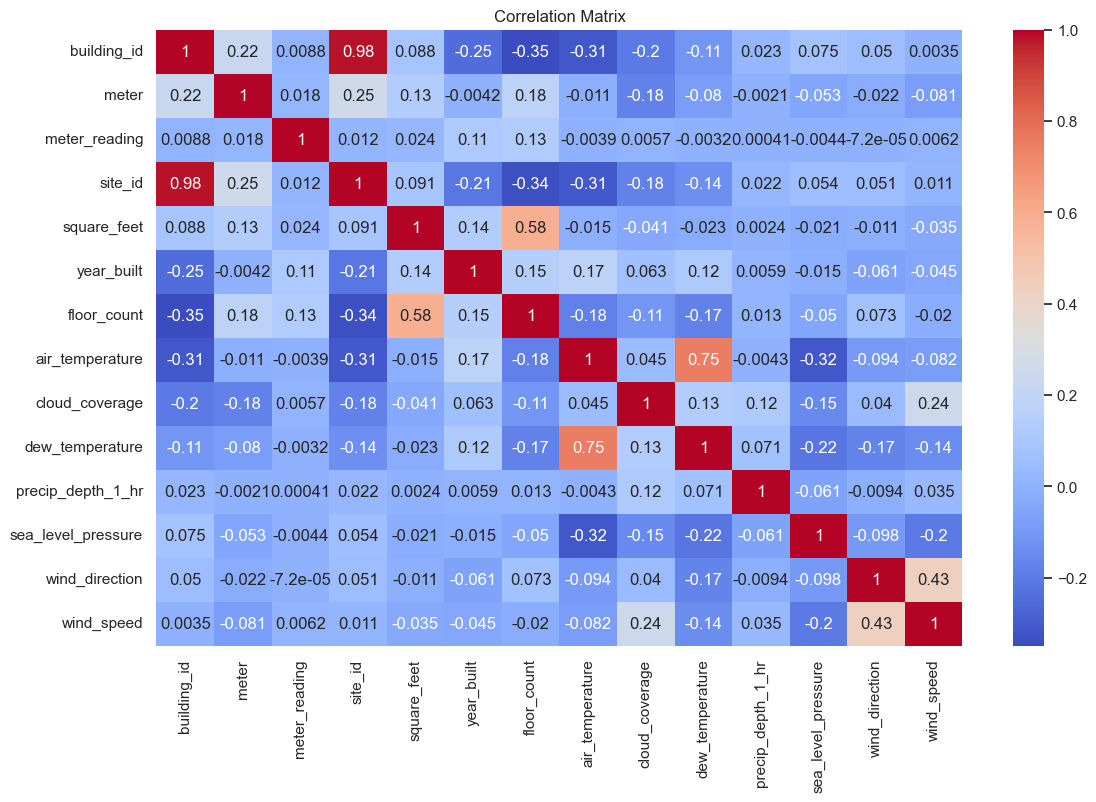

In [18]:
sns.set_theme(rc={"figure.figsize": (15, 9)}, font_scale=1.0)

# Select numerical columns from the sample dataframe
numerical_columns = train.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **Autocorrelation (lags 1 to 7)** 

Note: Not all times are available in the train dataset, so lag 1 may actually be some hours before, and not the previous hour.

In [19]:
# Create a list to store results
average_autocorrelation_data = []

# Create a DataFrame to store autocorrelation functions for each building and meter
autocorrelation_df = pd.DataFrame()

# Loop through each building_id and meter, and calculate average autocorrelation for lags 1 to 7
for building_id in train['building_id'].unique():
    for meter in train['meter'].unique():
        building_meter_data = train[(train['building_id'] == building_id) & (train['meter'] == meter)]

        # Check if the dataframe is not empty
        if not building_meter_data.empty:
            # Calculate autocorrelation for lags 1 to 7
            autocorrelation = sm.tsa.acf(building_meter_data['meter_reading'], nlags=7)

            # Calculate average autocorrelation
            avg_autocorrelation_data = {
                'building_id': building_id,
                'meter': meter,
                'average_autocorrelation': np.mean(autocorrelation)
            }

            # Add separate columns for each lag in the average autocorrelation table
            for lag, autocorr_value in enumerate(autocorrelation, start=1):
                avg_autocorrelation_data[f'lag_{lag}'] = autocorr_value

            # Append results to the list
            average_autocorrelation_data.append(avg_autocorrelation_data)

            # Append autocorrelation functions to the DataFrame
            autocorrelation_df = pd.concat([autocorrelation_df, pd.DataFrame(autocorrelation).T])

# Create a DataFrame from the list of average autocorrelation results
average_autocorrelation_df = pd.DataFrame(average_autocorrelation_data)

# Display the average autocorrelation DataFrame
#print("Average Autocorrelation by Building and Meter:")
average_autocorrelation_df

,building_id,meter,average_autocorrelation,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
0,1354,1,0.116711,1.0,-0.001736,-0.020010,-0.002300,-0.005593,0.011942,-0.020795,-0.027821
1,1354,2,0.115661,1.0,-0.004914,-0.021643,0.003732,-0.019272,-0.023368,-0.007540,-0.001710
2,273,1,0.119369,1.0,0.001263,0.015284,0.000834,-0.014026,-0.016375,-0.004875,-0.027155
3,273,0,0.124353,1.0,0.003743,-0.010921,0.000476,0.011566,-0.004597,-0.002372,-0.003072
4,266,0,0.129979,1.0,0.002176,0.015226,-0.001598,0.008176,-0.010999,0.024952,0.001899
...,...,...,...,...,...,...,...,...,...,...,...
2375,154,0,0.127370,1.0,0.012213,0.014526,-0.021264,0.005722,-0.008746,0.009421,0.007088
2376,644,0,0.128350,1.0,-0.002202,0.010116,0.013900,-0.012367,0.007316,-0.003345,0.013379
2377,1145,2,0.127588,1.0,0.011912,-0.020330,-0.001958,0.010022,-0.001578,0.012026,0.010609
2378,299,0,0.128716,1.0,0.006974,0.006548,0.016489,0.008810,0.017448,-0.002565,-0.023974


<Figure size 600x300 with 0 Axes>

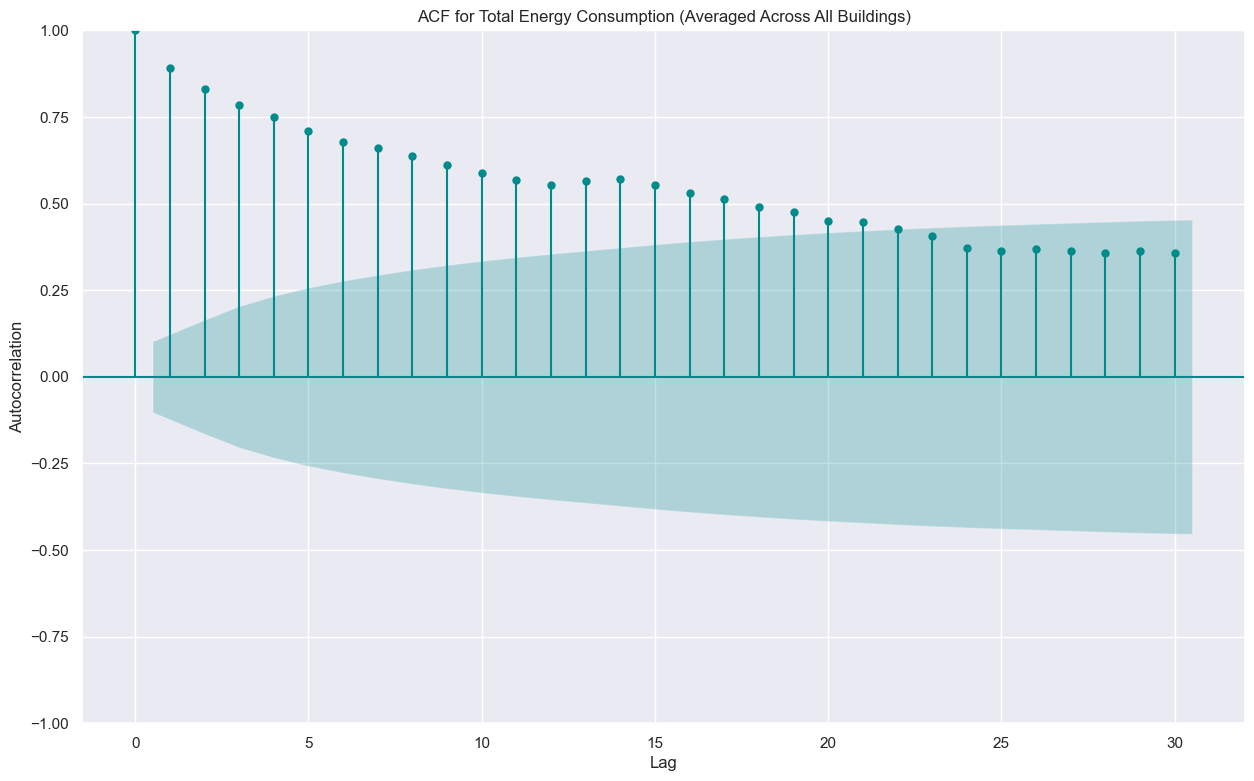

<Figure size 600x300 with 0 Axes>

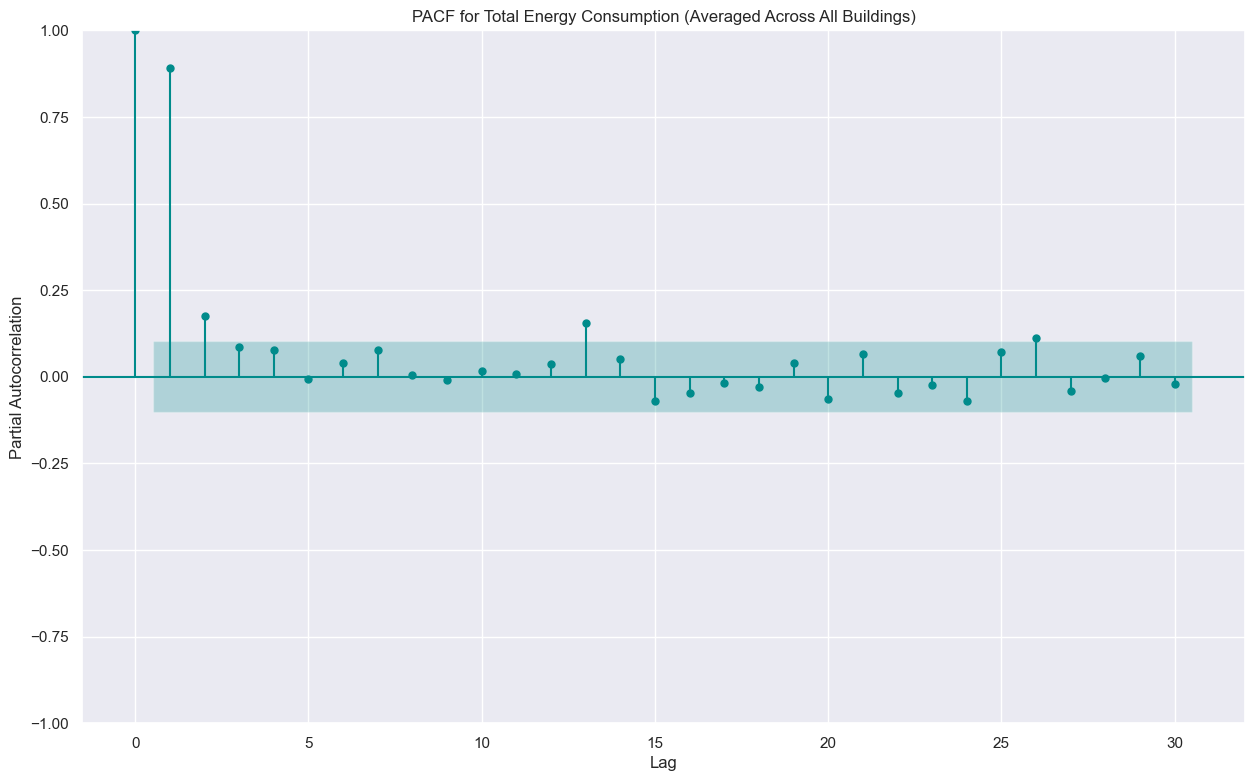

In [20]:
# Calculate total energy consumption for each date across all buildings
total_energy_consumption_all = train.groupby('date')['meter_reading'].sum()

# Set the color for the plots
color = 'darkcyan'

# Plot ACF for total energy consumption averaged across all buildings
plt.figure(figsize=(6, 3))
plot_acf(total_energy_consumption_all, lags=30, title='ACF for Total Energy Consumption (Averaged Across All Buildings)', color=color, vlines_kwargs={"colors": color})
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
#get polygon patch collections and change their color
for item in plt.gca().collections:
    if isinstance(item, PolyCollection):
        item.set_facecolor(color)
plt.show()

# Plot PACF for total energy consumption averaged across all buildings
plt.figure(figsize=(6, 3))
plot_pacf(total_energy_consumption_all, lags=30, title='PACF for Total Energy Consumption (Averaged Across All Buildings)', color=color, vlines_kwargs={"colors": color})
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
#get polygon patch collections and change their color
for item in plt.gca().collections:
    if isinstance(item, PolyCollection):
        item.set_facecolor(color)
plt.show()